In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from torchtext import data
import nltk
import json
from torchtext import vocab
from tqdm import tqdm
import torch
import random
import re
import os
import sys
import random
import tarfile
import urllib
from torchtext import data
import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/sunil.patel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sunil.patel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sunil.patel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sunil.patel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# DataSource : http://www.cs.cornell.edu/people/pabo/movie-review-data/
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
!tar -xvf rt-polaritydata.tar.gz

--2019-02-19 19:25:23--  http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20, 64:ff9b::84ec:cf14
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘rt-polaritydata.tar.gz.10’

100%[======================================>] 487,770     --.-K/s   in 0.007s  

2019-02-19 19:25:25 (66.5 MB/s) - ‘rt-polaritydata.tar.gz.10’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [3]:
SEED = 1
split = 0.80
data_block = []
negative_data  = open('rt-polaritydata/rt-polarity.neg',encoding='utf8',errors='ignore').read().splitlines()
for i in negative_data:
        data_block.append({"sentiment":str(i.strip()),"label" : 0}) 
positve_data  = open('rt-polaritydata/rt-polarity.pos',encoding='utf8',errors='ignore').read().splitlines()
for i in positve_data:
        data_block.append({"sentiment":str(i.strip()),"label" : 1}) 

In [4]:
random.shuffle(data_block)

train_file = open('train.json', 'w')
test_file = open('test.json', 'w')
for i in  range(0,int(len(data_block)*split)):
    train_file.write(str(json.dumps(data_block[i]))+"\n")
for i in  range(int(len(data_block)*split),len(data_block)):
    test_file.write(str(json.dumps(data_block[i]))+"\n")

In [5]:
def tokenize(sentiments):
#     print(sentiments)
    return sentiments
def pad_to_equal(x):
    if len(x) < 61:
        return x + ['<pad>' for i in range(0, 61 - len(x))]
    else:
        return x[:61]
def to_categorical(x):
    if x == 1:
        return [0,1]
    if x == 0:
        return [1,0]
    

In [6]:
SENTIMENT = data.Field(sequential=True , preprocessing =pad_to_equal , use_vocab = True, lower=True,batch_first=True)
LABEL = data.Field(is_target=True,use_vocab = False, sequential=False, preprocessing =to_categorical)
fields = {'sentiment': ('sentiment', SENTIMENT), 'label': ('label', LABEL)}
train_data , test_data = data.TabularDataset.splits(
                            path = '',
                            train = 'train.json',
                            test = 'test.json',
                            format = 'json',
                            fields = fields)

SENTIMENT.build_vocab(train_data, test_data)
LABEL.build_vocab(train_data, test_data)
train_iter, test_iter = data.Iterator.splits(
        (train_data, test_data), sort_key=lambda x: len(x.sentiment),
        batch_sizes=(16,len(test_data)), device=device,)

In [7]:
len(SENTIMENT.vocab)

21270

In [8]:
for batch in train_iter:
    feature, target = batch.sentiment, batch.label
    print(feature.data.shape, target.data.shape)
    break

torch.Size([16, 61]) torch.Size([16, 2])


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class CNN_Text(nn.Module):
    
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static, stride):
        super(CNN_Text, self).__init__() 
        self.embed_num = embed_num
        self.embed_dim = embed_dim 
        self.class_num = class_num 
        self.kernel_num = kernel_num
        self.kernel_sizes  = kernel_sizes 
        self.dropout = dropout
        self.static = static
        

        self.embed = nn.Embedding(embed_num, embed_dim)
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels=kernel_num, kernel_size= K,stride= stride) for K in kernel_sizes])
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_sizes)*kernel_num, class_num)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3) 
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embed(x)  # (N, W, D)
#         print("Embed shape : ", x.shape)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
#         print("Unsqueeze shape : ", x.shape)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
#         print ("After Convolution", x[0].shape)
        x = [F.max_pool1d(i, i.size(5)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        
        x = torch.cat(x, 1)
        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = F.relu(self.fc1(x))   # (N, C)
        logit  = torch.softmax(logit, dim=1)
        return logit

In [77]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == torch.argmax(y, dim=1)).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [78]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        feature, target = batch.sentiment, batch.label
        optimizer.zero_grad()
        predictions = model(feature)            
        loss = criterion(predictions.type(torch.FloatTensor), target.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        acc = binary_accuracy(predictions.type(torch.FloatTensor), target.type(torch.FloatTensor))
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return model, epoch_loss / len(iterator), epoch_acc / len(iterator)

In [79]:
def test_accuracy_calculator(model, test_iterator):
    epoch_acc = 0
    for batch in test_iterator:
        feature, target = batch.sentiment, batch.label
        predictions = model(feature)            
        acc = binary_accuracy(predictions.type(torch.FloatTensor), target.type(torch.FloatTensor))
        epoch_acc += acc.item()
    return  epoch_acc / len(test_iterator)

In [80]:
embed_num = len(SENTIMENT.vocab)
class_num = len(LABEL.vocab) - 1
kernel_sizes = [int(k) for k in '3,4,5'.split(',')]
embed_dim = 256
stride = 256
kernel_num  = 128
dropout = 0.3
static = False

In [81]:
cnn = CNN_Text( embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static, stride)
cnn = cnn.cuda()

In [44]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001 , weight_decay=0.0001)
criterion = nn.MSELoss()
criterion = criterion.to(device)

In [45]:
epochs  = 100
log_interval = 1
loss = []
accuracy = []
test_accuracy = []
for i in tqdm(range(epochs)):
    model, epoch_loss, epoch_acc = train(cnn, train_iter, optimizer, criterion)
    test_acc = test_accuracy_calculator(model, test_iter)
    accuracy.append(epoch_acc)
    loss.append(epoch_loss)
    test_accuracy.append(test_acc)
    print(epoch_acc,test_acc)

  1%|          | 1/100 [00:02<03:49,  2.32s/it]

0.9459905660377359 0.6182253956794739


  2%|▏         | 2/100 [00:04<03:44,  2.29s/it]

0.9478773584905661 0.6163069605827332


  3%|▎         | 3/100 [00:06<03:42,  2.29s/it]

0.9510613207547169 0.6115108132362366


  4%|▍         | 4/100 [00:09<03:38,  2.28s/it]

0.9537735849056603 0.6196642518043518


  5%|▌         | 5/100 [00:11<03:36,  2.28s/it]

0.9540094339622641 0.6211031079292297


  6%|▌         | 6/100 [00:13<03:34,  2.28s/it]

0.957322041156157 0.6345323920249939


  7%|▋         | 7/100 [00:15<03:31,  2.27s/it]

0.9571933962264151 0.631654679775238


  8%|▊         | 8/100 [00:18<03:29,  2.27s/it]

0.957311320754717 0.6268585324287415


  9%|▉         | 9/100 [00:20<03:27,  2.28s/it]

0.9588657804255215 0.6282973885536194


 10%|█         | 10/100 [00:22<03:24,  2.27s/it]

0.9594339622641509 0.6263788938522339


 11%|█         | 11/100 [00:25<03:22,  2.28s/it]

0.9609669811320755 0.6220623254776001


 12%|█▏        | 12/100 [00:27<03:20,  2.27s/it]

0.9608490566037736 0.6230216026306152


 13%|█▎        | 13/100 [00:29<03:18,  2.28s/it]

0.9600235849056604 0.623501181602478


 14%|█▍        | 14/100 [00:31<03:15,  2.27s/it]

0.9608490566037736 0.6225419640541077


 15%|█▌        | 15/100 [00:34<03:13,  2.28s/it]

0.9594339622641509 0.6273381114006042


 16%|█▌        | 16/100 [00:36<03:11,  2.28s/it]

0.9590801886792453 0.6244604587554932


 17%|█▋        | 17/100 [00:38<03:08,  2.28s/it]

0.961438679245283 0.6273381114006042


KeyboardInterrupt: 

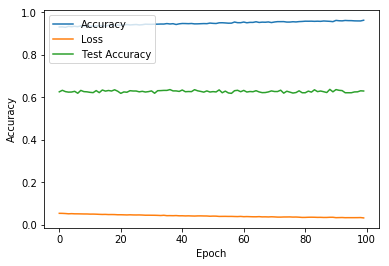

In [35]:
plt.plot(accuracy , label = "Accuracy")
plt.plot(loss , label = "Loss")
plt.plot(test_accuracy, label = "Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='upper left')
plt.show()

In [18]:
import numpy

In [19]:
conv13 = torch.nn.Conv2d(in_channels = 1, out_channels=100, kernel_size= 3,stride= 128)

In [20]:
example = torch.Tensor(numpy.random.random([16, 1, 31, 128]))

In [21]:
conv13(example).shape

torch.Size([16, 100, 1, 1])